In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
from tabulate import tabulate
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


            
            

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [3]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [4]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

files_add=find_the_way("./CV",".csv")
files_add

['./CV\\DoS-SYN.csv',
 './CV\\MB-ACK.csv',
 './CV\\MB-BF.csv',
 './CV\\MB-HDis.csv',
 './CV\\MB-HTTP.csv',
 './CV\\MB-UDP.csv',
 './CV\\MitM-ARP.csv',
 './CV\\Scan-HDis.csv',
 './CV\\Scan-OS.csv',
 './CV\\Scan-Port.csv',
 './CV\\SPScan-Port.csv']

In [5]:
ml_list={"ET": DecisionTreeClassifier()}#,"SVC":SVC()}}

In [6]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [7]:
folder("results/compare/SS/")
folder("results/compare/CV/")
folder("results/compare/DD/")
folder("pdfs")

## Calculation of evaluations

In [8]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [9]:
def ML(loop1,loop2,output_csv,cols,dname,sw):
    fold=5
    repetition=1
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Attack","Feature","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        for i in range(repetition):

                df = pd.read_csv(loop1,usecols=cols)#,header=None )
                df=df.fillna(0)
                X_train =df[df.columns[0:-1]]
                X_train=np.array(X_train)
                df[df.columns[-1]] = df[df.columns[-1]].astype('category')
                y_train=df[df.columns[-1]].cat.codes  


                df = pd.read_csv(loop2,usecols=cols)#,header=None )
                df=df.fillna(0)
                X_test =df[df.columns[0:-1]]
                X_test=np.array(X_test)
                df[df.columns[-1]] = df[df.columns[-1]].astype('category')
                y_test=df[df.columns[-1]].cat.codes  


                #dname=loop1  [6:-13]  
                results_y=[]
       
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )
    
                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)

                fig = plt.figure(figsize=(25,20))
                _ = tree.plot_tree(clf, 
                                   feature_names=cols[0:-1] ,
                                   class_names=["Benign","Attack"],
                                   filled=True)
                fig.savefig(f"{output_csv}.pdf",bbox_inches='tight',format="pdf")#, dpi=400)

        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
       
        results=results.mean()
        results=results.round(3)
        #print (tabulate(results, headers=list(results.columns)))
        #print()
        return list(results.values)






In [10]:
def ML_CV(loop1,loop2,output_csv,cols,dname,sw):
    fold=5
    repetition=5
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Attack","Feature","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  

                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )
    
                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)

        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)

        results=results.mean()
        results=results.round(3)
        #print (tabulate(results, headers=list(results.columns)))
        #print()
        return list(results.values)





In [11]:
features=[ 'IP_id','TCP_seq', 'TCP_ack',  'sport','dport', ]
    #['random', 'TCP_FIN_R', 'TCP_SYN_R', 'TCP_RST_R', 'TCP_PSH_R', 'TCP_ACK_R', 'TCP_URG_R', 'TCP_ECE_R', 'TCP_CWR_R']

In [12]:
len(features)

5

# Session vs Session

In [13]:
name_list=find_the_way("./SM",".csv")
name_list

['./SM\\DoS-SYN-1.csv',
 './SM\\DoS-SYN-2.csv',
 './SM\\MB-ACK-1.csv',
 './SM\\MB-ACK-2.csv',
 './SM\\MB-BF-1.csv',
 './SM\\MB-BF-2.csv',
 './SM\\MB-HDis-1.csv',
 './SM\\MB-HDis-2.csv',
 './SM\\MB-HTTP-1.csv',
 './SM\\MB-HTTP-2.csv',
 './SM\\MB-UDP-1.csv',
 './SM\\MB-UDP-2.csv',
 './SM\\MitM-ARP-1.csv',
 './SM\\MitM-ARP-2.csv',
 './SM\\Scan-HDis-1.csv',
 './SM\\Scan-HDis-2.csv',
 './SM\\Scan-OS-1.csv',
 './SM\\Scan-OS-2.csv',
 './SM\\Scan-Port-1.csv',
 './SM\\Scan-Port-2.csv',
 './SM\\SPScan-Port-1.csv',
 './SM\\SPScan-Port-2.csv']

In [14]:
unique=[]
for i in name_list:
    temp=i[5:-6]
    if temp not in unique:
        unique.append(temp)
        print(temp)

DoS-SYN
MB-ACK
MB-BF
MB-HDis
MB-HTTP
MB-UDP
MitM-ARP
Scan-HDis
Scan-OS
Scan-Port
SPScan-Port


In [15]:
unique=[
 'MB-ACK',
 'MB-BF',
 'MB-HDis',
 'MB-HTTP',
 'Scan-HDis',
 'Scan-OS',
 'Scan-Port',
 'SPScan-Port']

In [16]:
for i in unique:

    name_list=find_the_way("./SM",i)
    print(name_list)

['./SM\\MB-ACK-1.csv', './SM\\MB-ACK-2.csv']
['./SM\\MB-BF-1.csv', './SM\\MB-BF-2.csv']
['./SM\\MB-HDis-1.csv', './SM\\MB-HDis-2.csv']
['./SM\\MB-HTTP-1.csv', './SM\\MB-HTTP-2.csv']
['./SM\\Scan-HDis-1.csv', './SM\\Scan-HDis-2.csv']
['./SM\\Scan-OS-1.csv', './SM\\Scan-OS-2.csv']
['./SM\\Scan-Port-1.csv', './SM\\Scan-Port-2.csv', './SM\\SPScan-Port-1.csv', './SM\\SPScan-Port-2.csv']
['./SM\\SPScan-Port-1.csv', './SM\\SPScan-Port-2.csv']


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.94s/it]


      file  Attack             Feature    ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ------  -----------------  ---------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0       0  ./SM\MB-ACK-1.csv  IP_id      ET    1        1       1      1      1       1      1        0.004     0.001
 1       0  ./SM\MB-ACK-1.csv  TCP_seq    ET    0.995    0.998   0.97   0.998  0.983   0.967  0.998    0.016     0
 2       0  ./SM\MB-ACK-1.csv  TCP_ack    ET    0.4      0.676   0.553  0.676  0.358   0.073  0.676    0         0
 3       0  ./SM\MB-ACK-1.csv  sport      ET    0.646    0.443   0.482  0.443  0.429  -0.045  0.443    0.021     0
 4       0  ./SM\MB-ACK-1.csv  dport      ET    0.924    0.497   0.464  0.497  0.48   -0.009  0.497    0.013     0.004


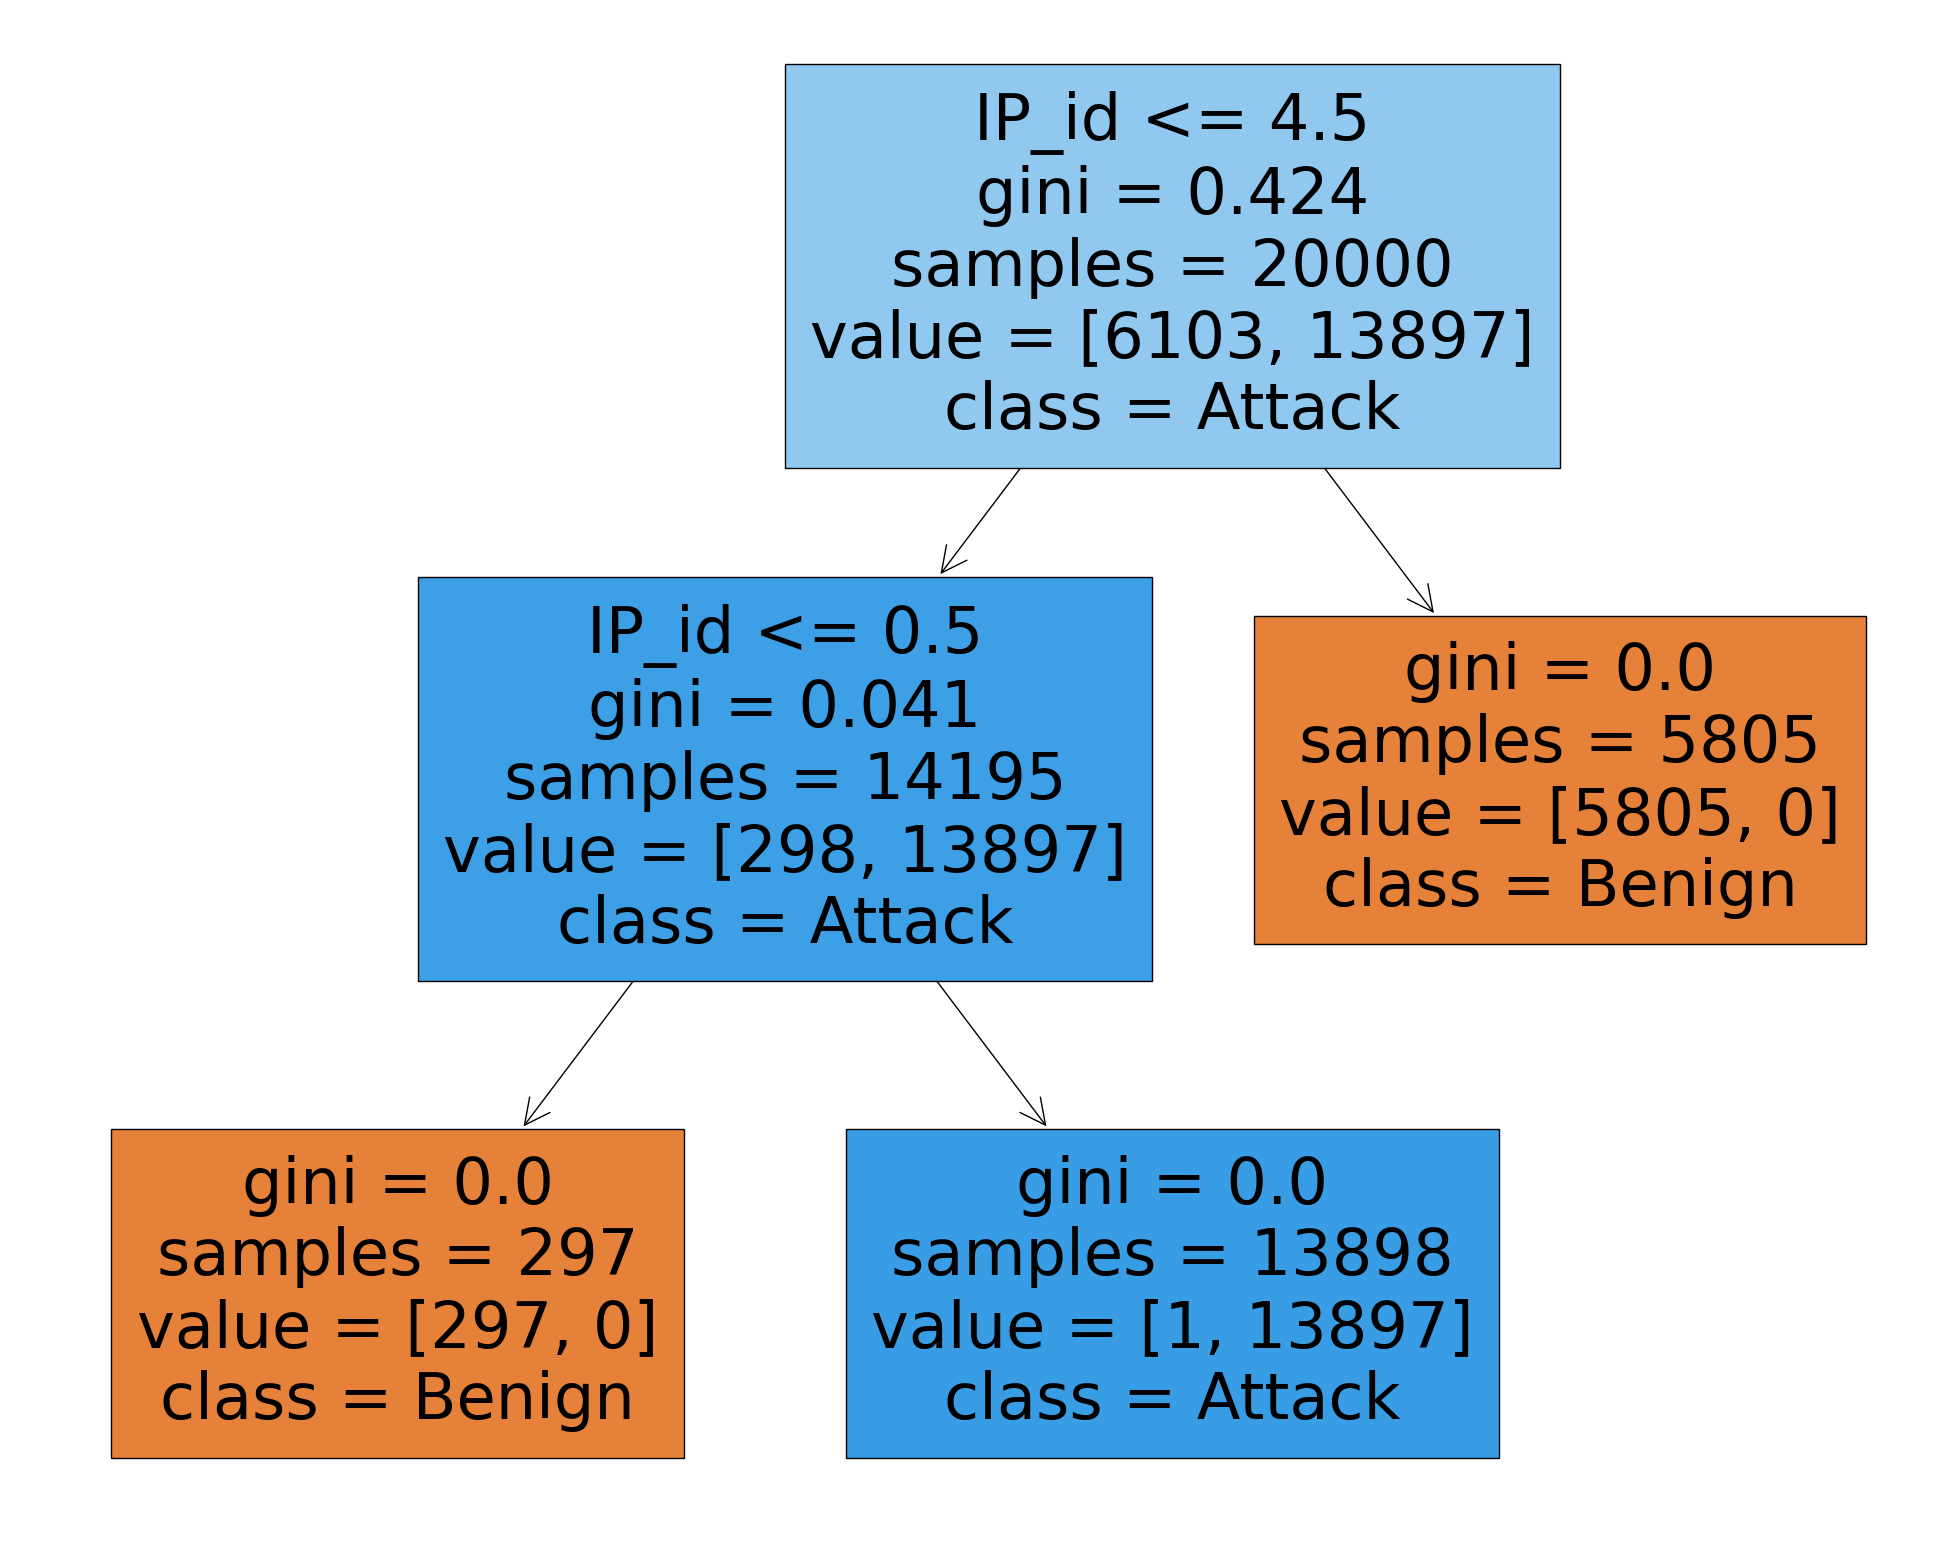

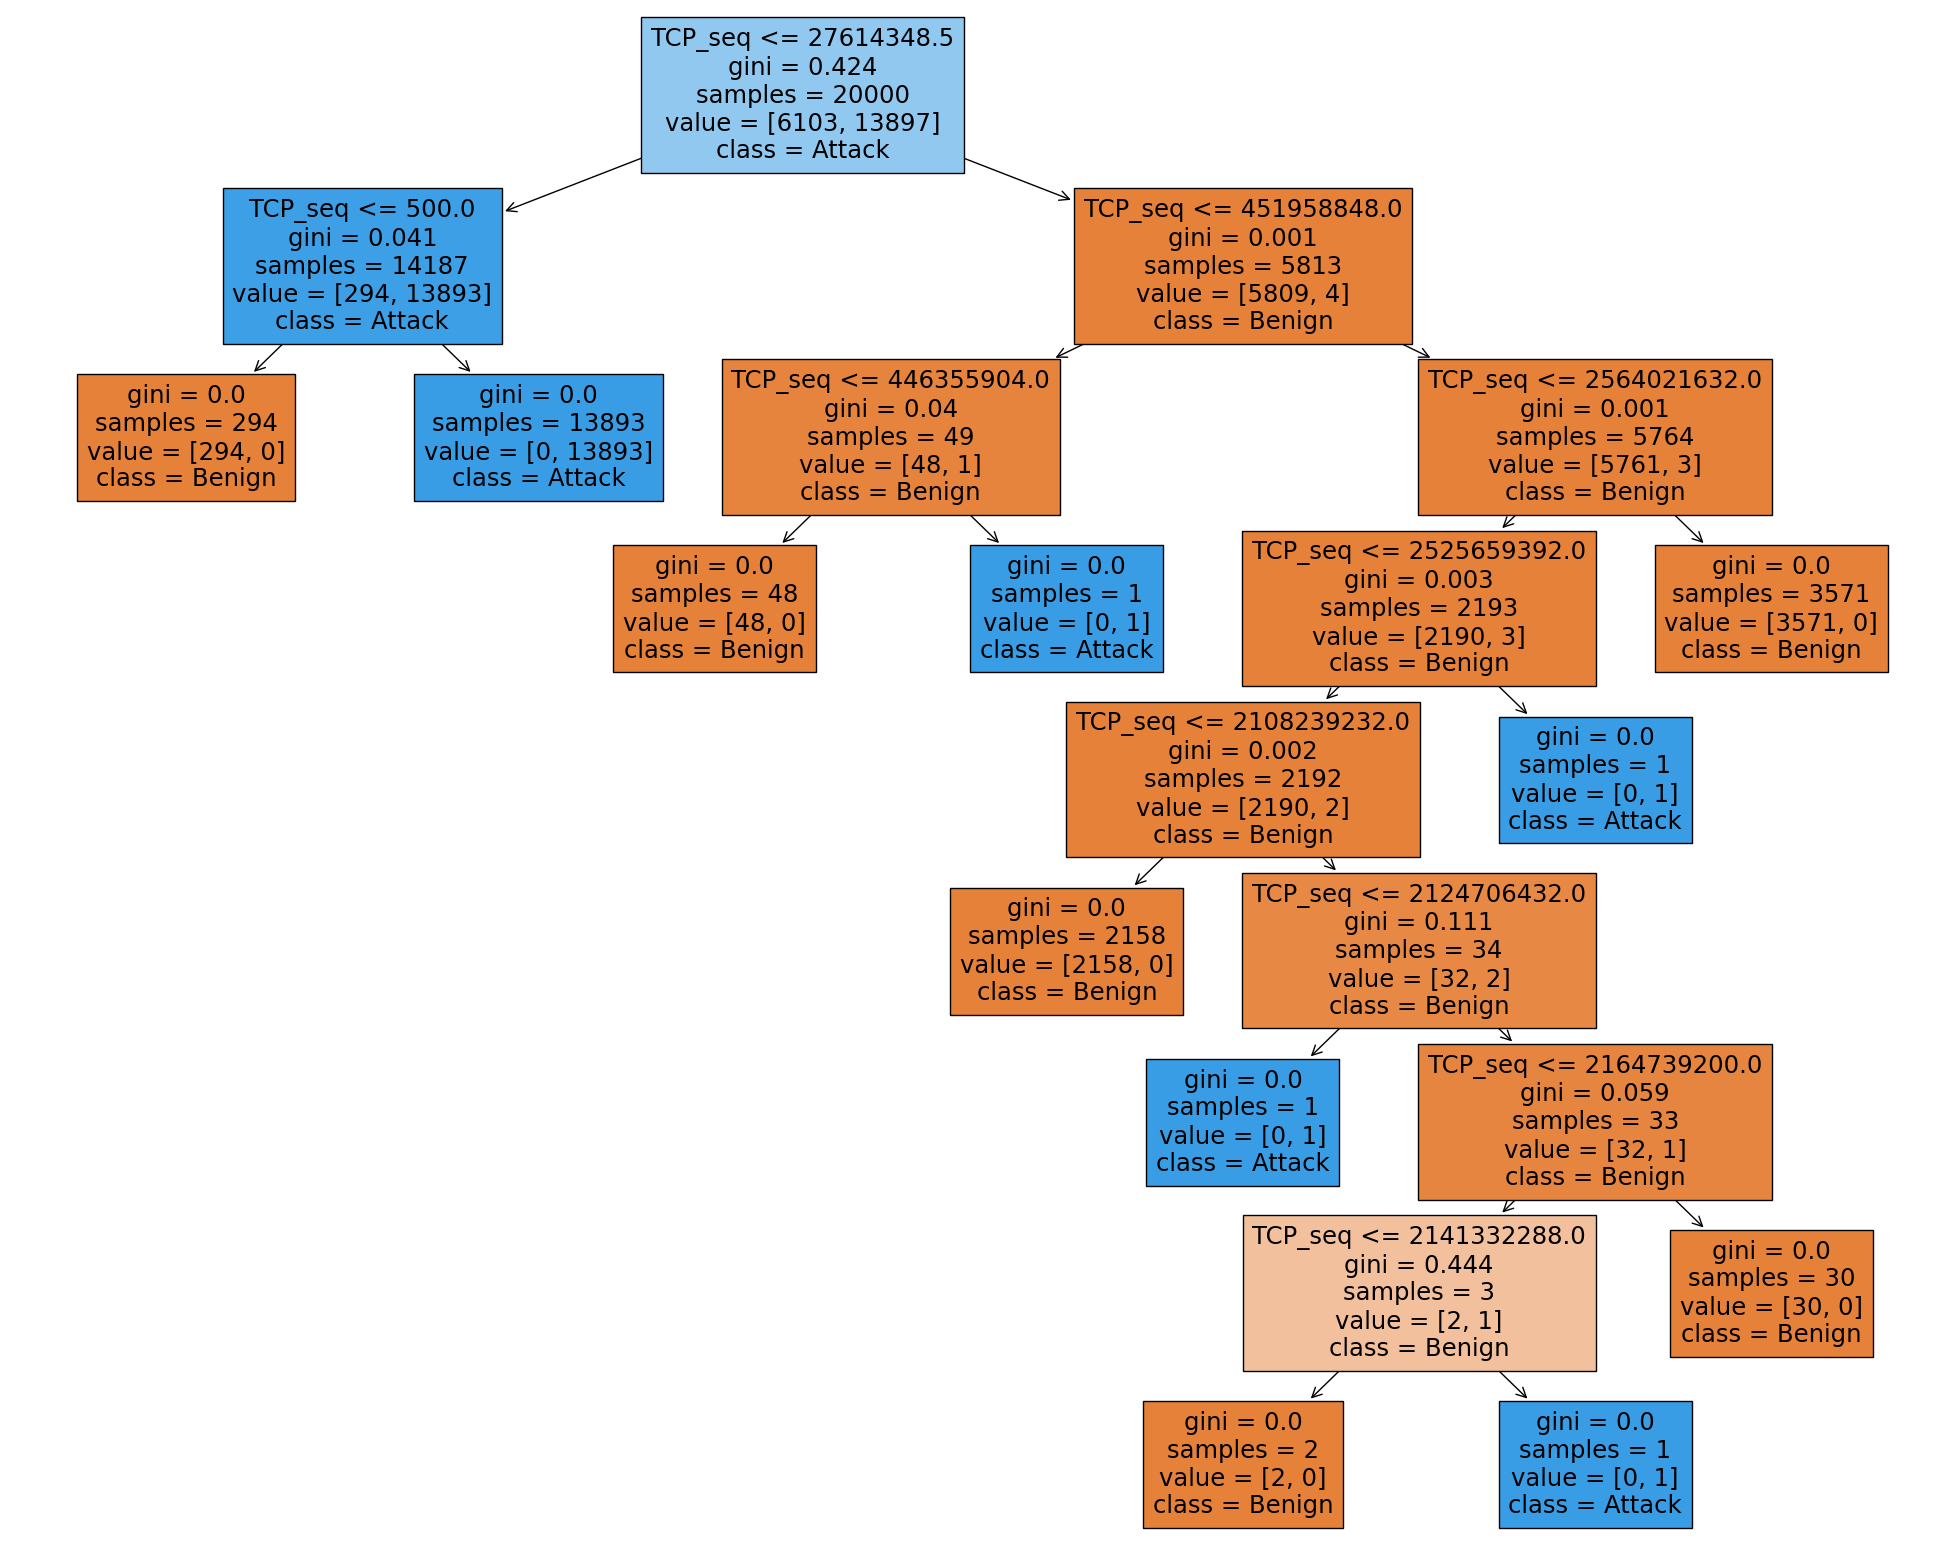

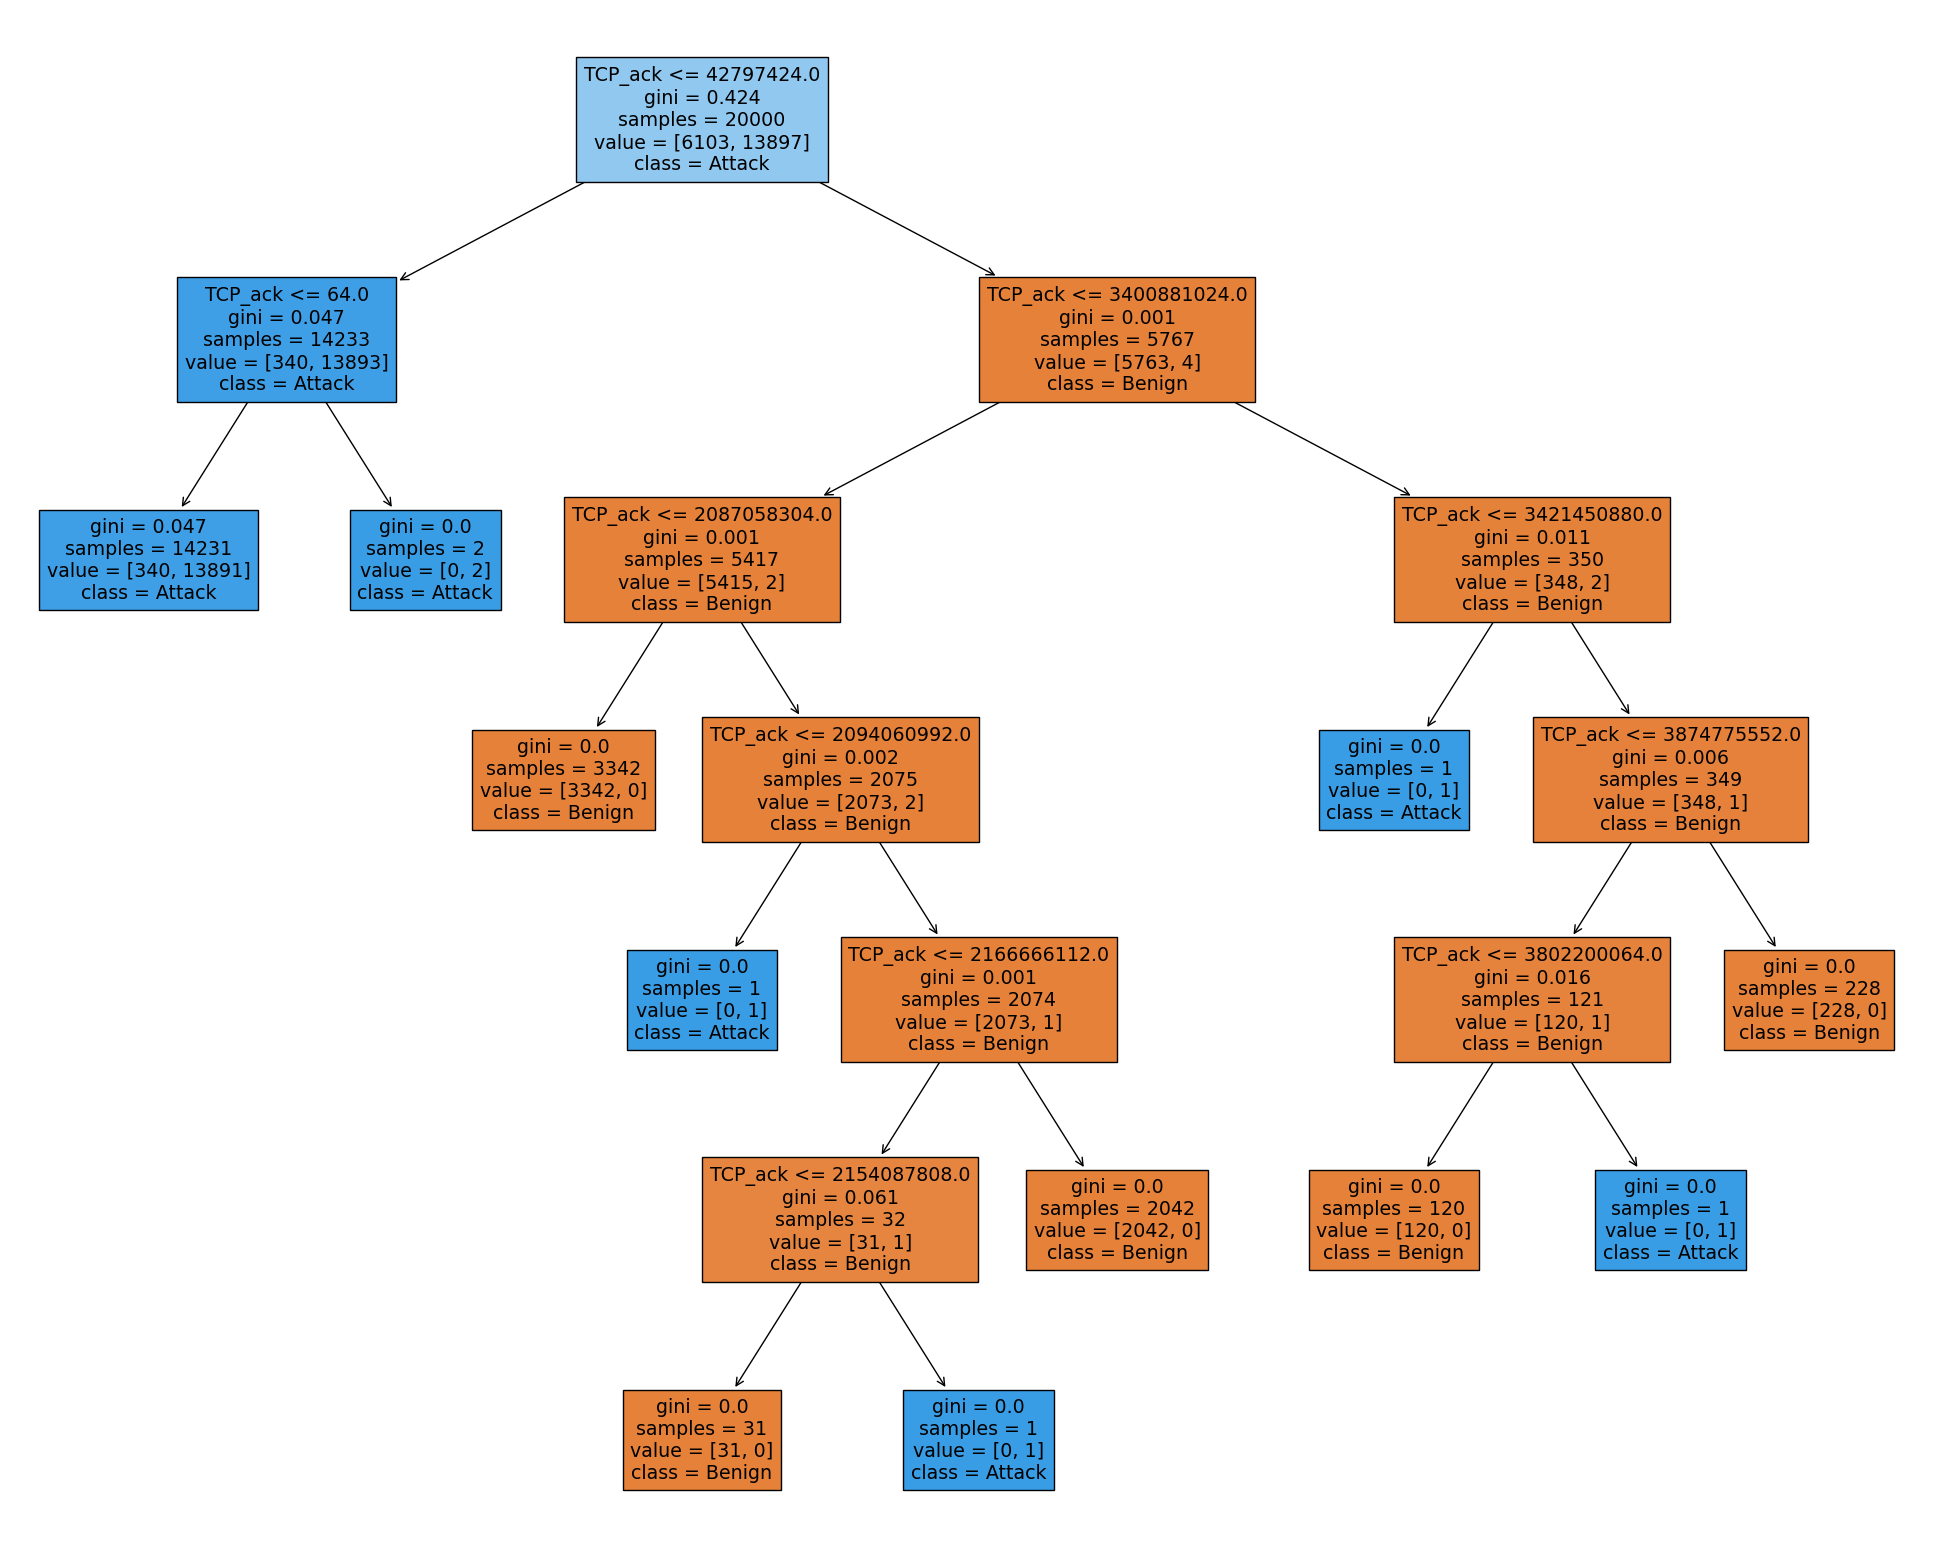

In [ ]:
for i in unique:
    file_list=find_the_way("./SM",i)
    train=file_list[0]
    for  no,test in enumerate(file_list[1:2]):
        lines=[["file","Attack","Feature","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        for dname in tqdm(features):
                target_names=["attack","benign"]
                feature=[dname, 'Label']
                output_csv=f"./results/compare/SS/ET_{i}_{dname}_{no}.csv"
                temp=ML(train,test,output_csv,feature,dname,train)  
                temp=temp[2:]
                temp=[no,train,dname,"ET"]+temp
                lines.append(temp)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        print (tabulate(results, headers=list(results.columns)))
        break
    break
